<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:19:46] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


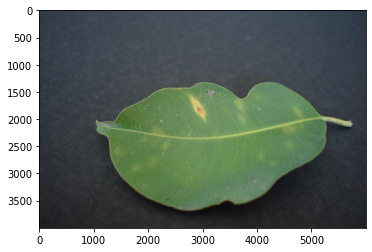

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

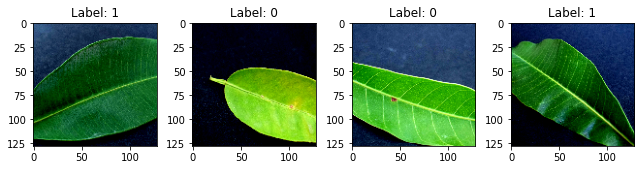

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:19:52] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:19:54] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.255344498475117 samples/sec                   batch loss = 0.4948863387107849 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.264444111490926 samples/sec                   batch loss = 0.5489538311958313 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.258744662764761 samples/sec                   batch loss = 1.112505555152893 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2575647048699965 samples/sec                   batch loss = 1.7313306331634521 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2615137684593736 samples/sec                   batch loss = 1.0715724229812622 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2609835575182462 samples/sec                   batch loss = 0.5364651083946228 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2537019300573802 samples/sec                   batch loss = 0.8461851477622986 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.258416192188289 samples/sec                   batch loss = 0.2293837070465088 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.2606856517755587 samples/sec                   batch loss = 1.2785555124282837 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2563993766386263 samples/sec                   batch loss = 0.3011530339717865 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.25824234874081 samples/sec                   batch loss = 0.5300670862197876 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2584717907019658 samples/sec                   batch loss = 0.7025939226150513 | accuracy = 0.5958333333333333


Epoch[1] Batch[65] Speed: 1.2569328954665142 samples/sec                   batch loss = 0.39378806948661804 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.255065211756332 samples/sec                   batch loss = 1.2503023147583008 | accuracy = 0.5928571428571429


Epoch[1] Batch[75] Speed: 1.25436997673423 samples/sec                   batch loss = 0.5037186145782471 | accuracy = 0.5933333333333334


Epoch[1] Batch[80] Speed: 1.2497992204815744 samples/sec                   batch loss = 1.604968786239624 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.247266950423617 samples/sec                   batch loss = 0.5325806140899658 | accuracy = 0.5852941176470589


Epoch[1] Batch[90] Speed: 1.2510791042875138 samples/sec                   batch loss = 0.8106754422187805 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.2533139144515386 samples/sec                   batch loss = 1.541709065437317 | accuracy = 0.5842105263157895


Epoch[1] Batch[100] Speed: 1.2463431624319254 samples/sec                   batch loss = 0.6982613801956177 | accuracy = 0.585


Epoch[1] Batch[105] Speed: 1.250523603897481 samples/sec                   batch loss = 0.5646955370903015 | accuracy = 0.6


Epoch[1] Batch[110] Speed: 1.2524618355671737 samples/sec                   batch loss = 0.7042156457901001 | accuracy = 0.6


Epoch[1] Batch[115] Speed: 1.2454257342160449 samples/sec                   batch loss = 0.5227092504501343 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.2583506885288003 samples/sec                   batch loss = 0.5858249664306641 | accuracy = 0.6041666666666666


Epoch[1] Batch[125] Speed: 1.2517512690260646 samples/sec                   batch loss = 0.5755151510238647 | accuracy = 0.6


Epoch[1] Batch[130] Speed: 1.2499476432379315 samples/sec                   batch loss = 0.40711483359336853 | accuracy = 0.6019230769230769


Epoch[1] Batch[135] Speed: 1.2548918235392146 samples/sec                   batch loss = 0.9199100732803345 | accuracy = 0.6018518518518519


Epoch[1] Batch[140] Speed: 1.2510461726809246 samples/sec                   batch loss = 0.7071581482887268 | accuracy = 0.5982142857142857


Epoch[1] Batch[145] Speed: 1.2509692146382616 samples/sec                   batch loss = 0.6348632574081421 | accuracy = 0.6068965517241379


Epoch[1] Batch[150] Speed: 1.2486267663967507 samples/sec                   batch loss = 0.6973507404327393 | accuracy = 0.6016666666666667


Epoch[1] Batch[155] Speed: 1.255672025114614 samples/sec                   batch loss = 0.4883780777454376 | accuracy = 0.5967741935483871


Epoch[1] Batch[160] Speed: 1.2518590542896308 samples/sec                   batch loss = 0.40276768803596497 | accuracy = 0.596875


Epoch[1] Batch[165] Speed: 1.252266919530216 samples/sec                   batch loss = 0.5369532704353333 | accuracy = 0.5954545454545455


Epoch[1] Batch[170] Speed: 1.238518438900716 samples/sec                   batch loss = 0.4548894762992859 | accuracy = 0.6


Epoch[1] Batch[175] Speed: 1.2413666859117831 samples/sec                   batch loss = 0.5444830656051636 | accuracy = 0.6014285714285714


Epoch[1] Batch[180] Speed: 1.2381950467522025 samples/sec                   batch loss = 0.5610858798027039 | accuracy = 0.6055555555555555


Epoch[1] Batch[185] Speed: 1.2372963229386638 samples/sec                   batch loss = 0.7872193455696106 | accuracy = 0.6040540540540541


Epoch[1] Batch[190] Speed: 1.2399681900555493 samples/sec                   batch loss = 0.3905493915081024 | accuracy = 0.6065789473684211


Epoch[1] Batch[195] Speed: 1.2401230867483648 samples/sec                   batch loss = 0.6473374962806702 | accuracy = 0.6064102564102564


Epoch[1] Batch[200] Speed: 1.2476485396185593 samples/sec                   batch loss = 0.5128499269485474 | accuracy = 0.6075


Epoch[1] Batch[205] Speed: 1.2446132427310277 samples/sec                   batch loss = 0.45860931277275085 | accuracy = 0.6109756097560975


Epoch[1] Batch[210] Speed: 1.2474201516766643 samples/sec                   batch loss = 0.73918217420578 | accuracy = 0.6107142857142858


Epoch[1] Batch[215] Speed: 1.2527102193838675 samples/sec                   batch loss = 0.7032190561294556 | accuracy = 0.6139534883720931


Epoch[1] Batch[220] Speed: 1.2506232536449269 samples/sec                   batch loss = 0.3833986818790436 | accuracy = 0.6193181818181818


Epoch[1] Batch[225] Speed: 1.2542133760504472 samples/sec                   batch loss = 0.6610385775566101 | accuracy = 0.6166666666666667


Epoch[1] Batch[230] Speed: 1.2539602720125231 samples/sec                   batch loss = 0.7091562747955322 | accuracy = 0.6173913043478261


Epoch[1] Batch[235] Speed: 1.2502454330524062 samples/sec                   batch loss = 0.3892308473587036 | accuracy = 0.6223404255319149


Epoch[1] Batch[240] Speed: 1.253960365735849 samples/sec                   batch loss = 1.0311890840530396 | accuracy = 0.6239583333333333


Epoch[1] Batch[245] Speed: 1.2514809535211762 samples/sec                   batch loss = 0.3466736674308777 | accuracy = 0.6285714285714286


Epoch[1] Batch[250] Speed: 1.247918408593887 samples/sec                   batch loss = 0.46704497933387756 | accuracy = 0.632


Epoch[1] Batch[255] Speed: 1.2477725089439156 samples/sec                   batch loss = 0.35342684388160706 | accuracy = 0.6333333333333333


Epoch[1] Batch[260] Speed: 1.2466431276050658 samples/sec                   batch loss = 0.3699909448623657 | accuracy = 0.635576923076923


Epoch[1] Batch[265] Speed: 1.2380711458530427 samples/sec                   batch loss = 0.4588589072227478 | accuracy = 0.6367924528301887


Epoch[1] Batch[270] Speed: 1.2358724733337263 samples/sec                   batch loss = 0.3490082025527954 | accuracy = 0.637962962962963


Epoch[1] Batch[275] Speed: 1.2498774313423684 samples/sec                   batch loss = 0.40332287549972534 | accuracy = 0.639090909090909


Epoch[1] Batch[280] Speed: 1.2475918522748906 samples/sec                   batch loss = 1.0612515211105347 | accuracy = 0.6419642857142858


Epoch[1] Batch[285] Speed: 1.2480802189010936 samples/sec                   batch loss = 0.467538446187973 | accuracy = 0.6447368421052632


Epoch[1] Batch[290] Speed: 1.2485527073791662 samples/sec                   batch loss = 0.8107650876045227 | accuracy = 0.6448275862068965


Epoch[1] Batch[295] Speed: 1.2464462215565482 samples/sec                   batch loss = 0.5880370736122131 | accuracy = 0.6457627118644068


Epoch[1] Batch[300] Speed: 1.2544016767209911 samples/sec                   batch loss = 0.8657755255699158 | accuracy = 0.6483333333333333


Epoch[1] Batch[305] Speed: 1.2495796306469815 samples/sec                   batch loss = 0.5999661684036255 | accuracy = 0.6475409836065574


Epoch[1] Batch[310] Speed: 1.2514206503454732 samples/sec                   batch loss = 0.5539684295654297 | accuracy = 0.6483870967741936


Epoch[1] Batch[315] Speed: 1.2461583838966648 samples/sec                   batch loss = 0.3676113188266754 | accuracy = 0.6507936507936508


Epoch[1] Batch[320] Speed: 1.2532989343547847 samples/sec                   batch loss = 0.33128857612609863 | accuracy = 0.6546875


Epoch[1] Batch[325] Speed: 1.24974950580891 samples/sec                   batch loss = 0.4865826964378357 | accuracy = 0.6538461538461539


Epoch[1] Batch[330] Speed: 1.250274781923869 samples/sec                   batch loss = 0.7480355501174927 | accuracy = 0.6522727272727272


Epoch[1] Batch[335] Speed: 1.2523319782813482 samples/sec                   batch loss = 0.39062830805778503 | accuracy = 0.6537313432835821


Epoch[1] Batch[340] Speed: 1.2526831879043896 samples/sec                   batch loss = 0.5497388243675232 | accuracy = 0.6551470588235294


Epoch[1] Batch[345] Speed: 1.2530884082561307 samples/sec                   batch loss = 0.39243119955062866 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.2488913877478311 samples/sec                   batch loss = 0.4964432716369629 | accuracy = 0.6607142857142857


Epoch[1] Batch[355] Speed: 1.2522723408346295 samples/sec                   batch loss = 0.06058396026492119 | accuracy = 0.6612676056338028


Epoch[1] Batch[360] Speed: 1.2549585634129645 samples/sec                   batch loss = 0.5611147880554199 | accuracy = 0.6597222222222222


Epoch[1] Batch[365] Speed: 1.2497592808535052 samples/sec                   batch loss = 0.6225489377975464 | accuracy = 0.660958904109589


Epoch[1] Batch[370] Speed: 1.2541198093959776 samples/sec                   batch loss = 0.45074257254600525 | accuracy = 0.6581081081081082


Epoch[1] Batch[375] Speed: 1.250774856118385 samples/sec                   batch loss = 0.5296160578727722 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.251587478437679 samples/sec                   batch loss = 0.3919422924518585 | accuracy = 0.6611842105263158


Epoch[1] Batch[385] Speed: 1.2480141157602433 samples/sec                   batch loss = 0.5463409423828125 | accuracy = 0.6623376623376623


Epoch[1] Batch[390] Speed: 1.247977817716058 samples/sec                   batch loss = 0.6026042699813843 | accuracy = 0.6634615384615384


Epoch[1] Batch[395] Speed: 1.2512297908331986 samples/sec                   batch loss = 0.22509126365184784 | accuracy = 0.6645569620253164


Epoch[1] Batch[400] Speed: 1.2470514010174893 samples/sec                   batch loss = 0.13902153074741364 | accuracy = 0.664375


Epoch[1] Batch[405] Speed: 1.2549857870593983 samples/sec                   batch loss = 0.2902916967868805 | accuracy = 0.6679012345679012


Epoch[1] Batch[410] Speed: 1.2500798008124037 samples/sec                   batch loss = 0.4842754006385803 | accuracy = 0.6689024390243903


Epoch[1] Batch[415] Speed: 1.2551938522702915 samples/sec                   batch loss = 0.8215361833572388 | accuracy = 0.6674698795180722


Epoch[1] Batch[420] Speed: 1.2541687473275345 samples/sec                   batch loss = 0.3949580192565918 | accuracy = 0.6696428571428571


Epoch[1] Batch[425] Speed: 1.248570640563489 samples/sec                   batch loss = 0.932453453540802 | accuracy = 0.6694117647058824


Epoch[1] Batch[430] Speed: 1.252746419074534 samples/sec                   batch loss = 0.3298940360546112 | accuracy = 0.6709302325581395


Epoch[1] Batch[435] Speed: 1.2482402137687076 samples/sec                   batch loss = 0.5762062668800354 | accuracy = 0.6724137931034483


Epoch[1] Batch[440] Speed: 1.256391567359941 samples/sec                   batch loss = 0.4438903331756592 | accuracy = 0.6727272727272727


Epoch[1] Batch[445] Speed: 1.2506229739695314 samples/sec                   batch loss = 0.3237884044647217 | accuracy = 0.6741573033707865


Epoch[1] Batch[450] Speed: 1.2478470323013955 samples/sec                   batch loss = 0.38192251324653625 | accuracy = 0.6766666666666666


Epoch[1] Batch[455] Speed: 1.256642736058838 samples/sec                   batch loss = 0.27779969573020935 | accuracy = 0.6785714285714286


Epoch[1] Batch[460] Speed: 1.254932373502321 samples/sec                   batch loss = 0.22393788397312164 | accuracy = 0.678804347826087


Epoch[1] Batch[465] Speed: 1.2488843222855726 samples/sec                   batch loss = 0.645607590675354 | accuracy = 0.678494623655914


Epoch[1] Batch[470] Speed: 1.255454876343365 samples/sec                   batch loss = 0.31342822313308716 | accuracy = 0.6803191489361702


Epoch[1] Batch[475] Speed: 1.255139763702801 samples/sec                   batch loss = 0.5394890904426575 | accuracy = 0.6805263157894736


Epoch[1] Batch[480] Speed: 1.2519309837251067 samples/sec                   batch loss = 0.7315508723258972 | accuracy = 0.6817708333333333


Epoch[1] Batch[485] Speed: 1.252529065288049 samples/sec                   batch loss = 0.4093354046344757 | accuracy = 0.6835051546391753


Epoch[1] Batch[490] Speed: 1.2577460928433617 samples/sec                   batch loss = 0.1511787623167038 | accuracy = 0.6846938775510204


Epoch[1] Batch[495] Speed: 1.2547944955491157 samples/sec                   batch loss = 0.4069991111755371 | accuracy = 0.6868686868686869


Epoch[1] Batch[500] Speed: 1.2506447890260146 samples/sec                   batch loss = 0.18436023592948914 | accuracy = 0.688


Epoch[1] Batch[505] Speed: 1.2457328426400613 samples/sec                   batch loss = 0.5927265286445618 | accuracy = 0.6876237623762376


Epoch[1] Batch[510] Speed: 1.2438226506848722 samples/sec                   batch loss = 0.5772942900657654 | accuracy = 0.6877450980392157


Epoch[1] Batch[515] Speed: 1.2477259247663008 samples/sec                   batch loss = 0.9050837755203247 | accuracy = 0.6878640776699029


Epoch[1] Batch[520] Speed: 1.2526703740812195 samples/sec                   batch loss = 0.3626074194908142 | accuracy = 0.6889423076923077


Epoch[1] Batch[525] Speed: 1.2450808917386529 samples/sec                   batch loss = 0.689288318157196 | accuracy = 0.6885714285714286


Epoch[1] Batch[530] Speed: 1.2484674156580966 samples/sec                   batch loss = 0.058512281626462936 | accuracy = 0.6886792452830188


Epoch[1] Batch[535] Speed: 1.249952392603226 samples/sec                   batch loss = 0.7084634900093079 | accuracy = 0.688785046728972


Epoch[1] Batch[540] Speed: 1.2481980521159315 samples/sec                   batch loss = 1.4713199138641357 | accuracy = 0.6893518518518519


Epoch[1] Batch[545] Speed: 1.2483575198713754 samples/sec                   batch loss = 0.7552387118339539 | accuracy = 0.689908256880734


Epoch[1] Batch[550] Speed: 1.2485010478209855 samples/sec                   batch loss = 0.6197819709777832 | accuracy = 0.6904545454545454


Epoch[1] Batch[555] Speed: 1.2470720719883657 samples/sec                   batch loss = 0.4148235619068146 | accuracy = 0.6905405405405406


Epoch[1] Batch[560] Speed: 1.2504045856769888 samples/sec                   batch loss = 0.27745771408081055 | accuracy = 0.6892857142857143


Epoch[1] Batch[565] Speed: 1.2529475665707108 samples/sec                   batch loss = 0.2742627263069153 | accuracy = 0.6889380530973451


Epoch[1] Batch[570] Speed: 1.2509368484477124 samples/sec                   batch loss = 0.5272199511528015 | accuracy = 0.6890350877192982


Epoch[1] Batch[575] Speed: 1.2504083133903092 samples/sec                   batch loss = 0.27301153540611267 | accuracy = 0.6891304347826087


Epoch[1] Batch[580] Speed: 1.2487913631226693 samples/sec                   batch loss = 0.47722992300987244 | accuracy = 0.6905172413793104


Epoch[1] Batch[585] Speed: 1.2455328027037447 samples/sec                   batch loss = 0.30520835518836975 | accuracy = 0.6901709401709402


Epoch[1] Batch[590] Speed: 1.2518943640705495 samples/sec                   batch loss = 0.2603943347930908 | accuracy = 0.6911016949152542


Epoch[1] Batch[595] Speed: 1.2464092738728656 samples/sec                   batch loss = 0.8956342935562134 | accuracy = 0.6911764705882353


Epoch[1] Batch[600] Speed: 1.2541978118914394 samples/sec                   batch loss = 0.8458564281463623 | accuracy = 0.69125


Epoch[1] Batch[605] Speed: 1.2487452605119111 samples/sec                   batch loss = 0.5117862820625305 | accuracy = 0.6929752066115702


Epoch[1] Batch[610] Speed: 1.2465096581522666 samples/sec                   batch loss = 0.39888378977775574 | accuracy = 0.6938524590163935


Epoch[1] Batch[615] Speed: 1.2484476274145062 samples/sec                   batch loss = 0.7907285094261169 | accuracy = 0.6947154471544715


Epoch[1] Batch[620] Speed: 1.2513638997239085 samples/sec                   batch loss = 0.39806950092315674 | accuracy = 0.6959677419354838


Epoch[1] Batch[625] Speed: 1.2530000626603992 samples/sec                   batch loss = 0.3772818446159363 | accuracy = 0.696


Epoch[1] Batch[630] Speed: 1.2520974806946845 samples/sec                   batch loss = 0.43357089161872864 | accuracy = 0.696031746031746


Epoch[1] Batch[635] Speed: 1.2514196235615331 samples/sec                   batch loss = 0.35705405473709106 | accuracy = 0.6960629921259842


Epoch[1] Batch[640] Speed: 1.2493723059197308 samples/sec                   batch loss = 0.5511462092399597 | accuracy = 0.696484375


Epoch[1] Batch[645] Speed: 1.2508902142307379 samples/sec                   batch loss = 0.6828081607818604 | accuracy = 0.6972868217054263


Epoch[1] Batch[650] Speed: 1.2431901076034357 samples/sec                   batch loss = 0.1952209174633026 | accuracy = 0.698076923076923


Epoch[1] Batch[655] Speed: 1.2436340093830633 samples/sec                   batch loss = 0.5061224102973938 | accuracy = 0.6980916030534351


Epoch[1] Batch[660] Speed: 1.2446033633606008 samples/sec                   batch loss = 0.40482664108276367 | accuracy = 0.6984848484848485


Epoch[1] Batch[665] Speed: 1.2359749006838403 samples/sec                   batch loss = 0.6510705351829529 | accuracy = 0.6977443609022557


Epoch[1] Batch[670] Speed: 1.2448911296360412 samples/sec                   batch loss = 0.20767231285572052 | accuracy = 0.6977611940298507


Epoch[1] Batch[675] Speed: 1.243240960071708 samples/sec                   batch loss = 0.8685140609741211 | accuracy = 0.6985185185185185


Epoch[1] Batch[680] Speed: 1.242884067308525 samples/sec                   batch loss = 0.11398401111364365 | accuracy = 0.6996323529411764


Epoch[1] Batch[685] Speed: 1.24293452641263 samples/sec                   batch loss = 0.8412227630615234 | accuracy = 0.698905109489051


Epoch[1] Batch[690] Speed: 1.2453549200981158 samples/sec                   batch loss = 1.1374377012252808 | accuracy = 0.6981884057971014


Epoch[1] Batch[695] Speed: 1.248604464137002 samples/sec                   batch loss = 0.7210557460784912 | accuracy = 0.6989208633093525


Epoch[1] Batch[700] Speed: 1.2492771345315725 samples/sec                   batch loss = 0.7415291666984558 | accuracy = 0.6996428571428571


Epoch[1] Batch[705] Speed: 1.2443523691750213 samples/sec                   batch loss = 0.3961524963378906 | accuracy = 0.699645390070922


Epoch[1] Batch[710] Speed: 1.2540207264675691 samples/sec                   batch loss = 0.9485811591148376 | accuracy = 0.6992957746478873


Epoch[1] Batch[715] Speed: 1.2458328404496821 samples/sec                   batch loss = 0.2951912581920624 | accuracy = 0.6986013986013986


Epoch[1] Batch[720] Speed: 1.246153015399674 samples/sec                   batch loss = 0.0792396143078804 | accuracy = 0.6993055555555555


Epoch[1] Batch[725] Speed: 1.2471345525415103 samples/sec                   batch loss = 1.1266047954559326 | accuracy = 0.6986206896551724


Epoch[1] Batch[730] Speed: 1.2494854512820894 samples/sec                   batch loss = 0.23021632432937622 | accuracy = 0.6993150684931507


Epoch[1] Batch[735] Speed: 1.2515883187588868 samples/sec                   batch loss = 0.7001191973686218 | accuracy = 0.6989795918367347


Epoch[1] Batch[740] Speed: 1.2488936189630482 samples/sec                   batch loss = 0.6821986436843872 | accuracy = 0.6996621621621621


Epoch[1] Batch[745] Speed: 1.2521370092066 samples/sec                   batch loss = 0.5736422538757324 | accuracy = 0.7006711409395974


Epoch[1] Batch[750] Speed: 1.2551605158832582 samples/sec                   batch loss = 0.6354125738143921 | accuracy = 0.7006666666666667


Epoch[1] Batch[755] Speed: 1.2494614433987177 samples/sec                   batch loss = 1.0250056982040405 | accuracy = 0.7016556291390729


Epoch[1] Batch[760] Speed: 1.2464253861272419 samples/sec                   batch loss = 0.26327940821647644 | accuracy = 0.7019736842105263


Epoch[1] Batch[765] Speed: 1.2447347625823466 samples/sec                   batch loss = 0.6914178133010864 | accuracy = 0.7009803921568627


Epoch[1] Batch[770] Speed: 1.2465292923925395 samples/sec                   batch loss = 0.30735039710998535 | accuracy = 0.7016233766233766


Epoch[1] Batch[775] Speed: 1.2539676761984273 samples/sec                   batch loss = 0.2789115905761719 | accuracy = 0.702258064516129


Epoch[1] Batch[780] Speed: 1.2550875576319556 samples/sec                   batch loss = 0.4896131455898285 | accuracy = 0.7025641025641025


Epoch[1] Batch[785] Speed: 1.2519806852545259 samples/sec                   batch loss = 0.2123219221830368 | accuracy = 0.7028662420382166


[Epoch 1] training: accuracy=0.7030456852791879
[Epoch 1] time cost: 652.6634938716888
[Epoch 1] validation: validation accuracy=0.7555555555555555


Epoch[2] Batch[5] Speed: 1.2646231999778692 samples/sec                   batch loss = 0.26795241236686707 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.263203609356245 samples/sec                   batch loss = 0.294002503156662 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2596689629282027 samples/sec                   batch loss = 0.2950647473335266 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2537013679494031 samples/sec                   batch loss = 0.4108761250972748 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.2630186472210823 samples/sec                   batch loss = 0.17122310400009155 | accuracy = 0.85


Epoch[2] Batch[30] Speed: 1.2669529136370166 samples/sec                   batch loss = 0.291740357875824 | accuracy = 0.8666666666666667


Epoch[2] Batch[35] Speed: 1.2568624615967798 samples/sec                   batch loss = 0.8358584046363831 | accuracy = 0.8428571428571429


Epoch[2] Batch[40] Speed: 1.2605229243244434 samples/sec                   batch loss = 0.20816411077976227 | accuracy = 0.825


Epoch[2] Batch[45] Speed: 1.2644771804262929 samples/sec                   batch loss = 0.09666286408901215 | accuracy = 0.8333333333333334


Epoch[2] Batch[50] Speed: 1.259248228653777 samples/sec                   batch loss = 0.9091330170631409 | accuracy = 0.81


Epoch[2] Batch[55] Speed: 1.2617084426888896 samples/sec                   batch loss = 0.529098391532898 | accuracy = 0.8


Epoch[2] Batch[60] Speed: 1.2603909167379668 samples/sec                   batch loss = 0.35486653447151184 | accuracy = 0.7958333333333333


Epoch[2] Batch[65] Speed: 1.255630017740401 samples/sec                   batch loss = 0.6915210485458374 | accuracy = 0.7769230769230769


Epoch[2] Batch[70] Speed: 1.258601980293984 samples/sec                   batch loss = 0.610150158405304 | accuracy = 0.775


Epoch[2] Batch[75] Speed: 1.261262071277342 samples/sec                   batch loss = 1.1097691059112549 | accuracy = 0.7733333333333333


Epoch[2] Batch[80] Speed: 1.2593112736144094 samples/sec                   batch loss = 0.2389693409204483 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.2554129774372784 samples/sec                   batch loss = 0.5654997825622559 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.256540054366733 samples/sec                   batch loss = 0.5387628674507141 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2607165349520273 samples/sec                   batch loss = 0.3034158945083618 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2649149588046547 samples/sec                   batch loss = 0.7072649002075195 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2628397277022312 samples/sec                   batch loss = 0.6979159116744995 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.2571974696313575 samples/sec                   batch loss = 0.28244903683662415 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.2600242057920412 samples/sec                   batch loss = 0.4755111634731293 | accuracy = 0.7521739130434782


Epoch[2] Batch[120] Speed: 1.2589894040487504 samples/sec                   batch loss = 0.4794194996356964 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.2640718955838974 samples/sec                   batch loss = 0.25801053643226624 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2485180504050395 samples/sec                   batch loss = 0.7754592895507812 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2485111749874123 samples/sec                   batch loss = 0.9340417385101318 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.2528467976350273 samples/sec                   batch loss = 0.31760352849960327 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.252506810422765 samples/sec                   batch loss = 0.43890127539634705 | accuracy = 0.7551724137931034


Epoch[2] Batch[150] Speed: 1.2516486380951968 samples/sec                   batch loss = 0.41406428813934326 | accuracy = 0.7516666666666667


Epoch[2] Batch[155] Speed: 1.2536221157703662 samples/sec                   batch loss = 0.723618745803833 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.2480888536767263 samples/sec                   batch loss = 0.3541332483291626 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2573378550048888 samples/sec                   batch loss = 0.3000026047229767 | accuracy = 0.7545454545454545


Epoch[2] Batch[170] Speed: 1.2568913686604386 samples/sec                   batch loss = 0.6979590058326721 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2480994384033997 samples/sec                   batch loss = 0.8194945454597473 | accuracy = 0.7514285714285714


Epoch[2] Batch[180] Speed: 1.2559887214757905 samples/sec                   batch loss = 0.5274758338928223 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.259877827141611 samples/sec                   batch loss = 0.6128106117248535 | accuracy = 0.7472972972972973


Epoch[2] Batch[190] Speed: 1.2547902724004891 samples/sec                   batch loss = 0.2605917453765869 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.2535255465770234 samples/sec                   batch loss = 0.4492834508419037 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2560168361135864 samples/sec                   batch loss = 0.38910725712776184 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.2583222805603298 samples/sec                   batch loss = 0.3783901035785675 | accuracy = 0.751219512195122


Epoch[2] Batch[210] Speed: 1.2543786049742944 samples/sec                   batch loss = 1.36241614818573 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.262537809047622 samples/sec                   batch loss = 0.4207007586956024 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2616938305492627 samples/sec                   batch loss = 0.27674487233161926 | accuracy = 0.7443181818181818


Epoch[2] Batch[225] Speed: 1.2536011334195658 samples/sec                   batch loss = 0.3662659227848053 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2550877454157943 samples/sec                   batch loss = 0.6384710669517517 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.2504773732993983 samples/sec                   batch loss = 0.5177438855171204 | accuracy = 0.7393617021276596


Epoch[2] Batch[240] Speed: 1.252745670739338 samples/sec                   batch loss = 0.3055376708507538 | accuracy = 0.7385416666666667


Epoch[2] Batch[245] Speed: 1.253120979478793 samples/sec                   batch loss = 0.49829357862472534 | accuracy = 0.7387755102040816


Epoch[2] Batch[250] Speed: 1.250726089443544 samples/sec                   batch loss = 0.719448447227478 | accuracy = 0.74


Epoch[2] Batch[255] Speed: 1.2514213037543125 samples/sec                   batch loss = 1.1093523502349854 | accuracy = 0.7401960784313726


Epoch[2] Batch[260] Speed: 1.2579858239412383 samples/sec                   batch loss = 0.6918923854827881 | accuracy = 0.7413461538461539


Epoch[2] Batch[265] Speed: 1.251405622130492 samples/sec                   batch loss = 0.3769884407520294 | accuracy = 0.7405660377358491


Epoch[2] Batch[270] Speed: 1.25119246570638 samples/sec                   batch loss = 0.27373069524765015 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2541739038454134 samples/sec                   batch loss = 0.6512025594711304 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.2556198687292786 samples/sec                   batch loss = 0.3968101143836975 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2635904456108027 samples/sec                   batch loss = 0.4257417619228363 | accuracy = 0.7464912280701754


Epoch[2] Batch[290] Speed: 1.2600395363576846 samples/sec                   batch loss = 0.4350108504295349 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.2490658184514358 samples/sec                   batch loss = 0.3467686176300049 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.2490126286601566 samples/sec                   batch loss = 0.7007008790969849 | accuracy = 0.7491666666666666


Epoch[2] Batch[305] Speed: 1.251548638155517 samples/sec                   batch loss = 0.4137685000896454 | accuracy = 0.7475409836065574


Epoch[2] Batch[310] Speed: 1.2522134567662393 samples/sec                   batch loss = 0.1585407704114914 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.25280451132255 samples/sec                   batch loss = 0.469165176153183 | accuracy = 0.7484126984126984


Epoch[2] Batch[320] Speed: 1.2446853576526948 samples/sec                   batch loss = 0.7229384779930115 | accuracy = 0.74921875


Epoch[2] Batch[325] Speed: 1.2605581562742898 samples/sec                   batch loss = 0.26693692803382874 | accuracy = 0.7476923076923077


Epoch[2] Batch[330] Speed: 1.2497996859934546 samples/sec                   batch loss = 0.4614361822605133 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2538950439758207 samples/sec                   batch loss = 0.712334156036377 | accuracy = 0.7477611940298508


Epoch[2] Batch[340] Speed: 1.2655804052626405 samples/sec                   batch loss = 1.136987566947937 | accuracy = 0.7470588235294118


Epoch[2] Batch[345] Speed: 1.2535442785260775 samples/sec                   batch loss = 0.3036302626132965 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2680396670533645 samples/sec                   batch loss = 0.5948399901390076 | accuracy = 0.7471428571428571


Epoch[2] Batch[355] Speed: 1.2540351614165475 samples/sec                   batch loss = 0.4194978177547455 | accuracy = 0.747887323943662


Epoch[2] Batch[360] Speed: 1.251768360251565 samples/sec                   batch loss = 0.3965962529182434 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.2565761933968471 samples/sec                   batch loss = 0.45485129952430725 | accuracy = 0.7452054794520548


Epoch[2] Batch[370] Speed: 1.2577281779811267 samples/sec                   batch loss = 0.9650463461875916 | accuracy = 0.7418918918918919


Epoch[2] Batch[375] Speed: 1.2562840349972848 samples/sec                   batch loss = 0.264448881149292 | accuracy = 0.7426666666666667


Epoch[2] Batch[380] Speed: 1.2561468003933784 samples/sec                   batch loss = 0.5048903226852417 | accuracy = 0.7421052631578947


Epoch[2] Batch[385] Speed: 1.2523859186069366 samples/sec                   batch loss = 0.36795637011528015 | accuracy = 0.740909090909091


Epoch[2] Batch[390] Speed: 1.262787924660319 samples/sec                   batch loss = 0.16657255589962006 | accuracy = 0.7397435897435898


Epoch[2] Batch[395] Speed: 1.265352563246827 samples/sec                   batch loss = 0.4682078957557678 | accuracy = 0.7411392405063291


Epoch[2] Batch[400] Speed: 1.266439535292046 samples/sec                   batch loss = 0.2723050117492676 | accuracy = 0.741875


Epoch[2] Batch[405] Speed: 1.265076055903019 samples/sec                   batch loss = 0.30641621351242065 | accuracy = 0.7425925925925926


Epoch[2] Batch[410] Speed: 1.2627382167463712 samples/sec                   batch loss = 0.37125152349472046 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.2583264331401278 samples/sec                   batch loss = 0.4554542303085327 | accuracy = 0.7457831325301205


Epoch[2] Batch[420] Speed: 1.263667536718345 samples/sec                   batch loss = 0.6030771732330322 | accuracy = 0.7452380952380953


Epoch[2] Batch[425] Speed: 1.2499604945449692 samples/sec                   batch loss = 0.32743844389915466 | accuracy = 0.7441176470588236


Epoch[2] Batch[430] Speed: 1.2557223060923117 samples/sec                   batch loss = 0.7282009124755859 | accuracy = 0.7430232558139535


Epoch[2] Batch[435] Speed: 1.252845768509462 samples/sec                   batch loss = 0.7344018816947937 | accuracy = 0.7419540229885058


Epoch[2] Batch[440] Speed: 1.2481161514952614 samples/sec                   batch loss = 0.5451996922492981 | accuracy = 0.7443181818181818


Epoch[2] Batch[445] Speed: 1.246243452979187 samples/sec                   batch loss = 0.6107435822486877 | accuracy = 0.7438202247191011


Epoch[2] Batch[450] Speed: 1.2557442054217482 samples/sec                   batch loss = 0.19505739212036133 | accuracy = 0.745


Epoch[2] Batch[455] Speed: 1.2591161099194137 samples/sec                   batch loss = 1.0571215152740479 | accuracy = 0.7445054945054945


Epoch[2] Batch[460] Speed: 1.2564531033437907 samples/sec                   batch loss = 0.329570472240448 | accuracy = 0.746195652173913


Epoch[2] Batch[465] Speed: 1.2568881671612022 samples/sec                   batch loss = 0.3687567114830017 | accuracy = 0.7462365591397849


Epoch[2] Batch[470] Speed: 1.2570960159628233 samples/sec                   batch loss = 0.6004263758659363 | accuracy = 0.7436170212765958


Epoch[2] Batch[475] Speed: 1.2564617602655095 samples/sec                   batch loss = 0.586063027381897 | accuracy = 0.7426315789473684


Epoch[2] Batch[480] Speed: 1.2556843365331403 samples/sec                   batch loss = 0.4622225761413574 | accuracy = 0.7427083333333333


Epoch[2] Batch[485] Speed: 1.2558089679938633 samples/sec                   batch loss = 1.3102003335952759 | accuracy = 0.7412371134020619


Epoch[2] Batch[490] Speed: 1.2562211046471796 samples/sec                   batch loss = 0.3637504577636719 | accuracy = 0.7423469387755102


Epoch[2] Batch[495] Speed: 1.256934496328026 samples/sec                   batch loss = 0.4722538888454437 | accuracy = 0.7429292929292929


Epoch[2] Batch[500] Speed: 1.2479954558881277 samples/sec                   batch loss = 0.50165855884552 | accuracy = 0.7415


Epoch[2] Batch[505] Speed: 1.2544584218223456 samples/sec                   batch loss = 0.35414791107177734 | accuracy = 0.7425742574257426


Epoch[2] Batch[510] Speed: 1.2478631817490775 samples/sec                   batch loss = 0.14600123465061188 | accuracy = 0.7431372549019608


Epoch[2] Batch[515] Speed: 1.2582252689959046 samples/sec                   batch loss = 0.3467942476272583 | accuracy = 0.7446601941747573


Epoch[2] Batch[520] Speed: 1.261133985172677 samples/sec                   batch loss = 1.954362154006958 | accuracy = 0.74375


Epoch[2] Batch[525] Speed: 1.2540943106845786 samples/sec                   batch loss = 0.6102423071861267 | accuracy = 0.7442857142857143


Epoch[2] Batch[530] Speed: 1.2592224264649314 samples/sec                   batch loss = 0.21399162709712982 | accuracy = 0.7433962264150943


Epoch[2] Batch[535] Speed: 1.2635408648195876 samples/sec                   batch loss = 0.53490149974823 | accuracy = 0.741588785046729


Epoch[2] Batch[540] Speed: 1.257771268801759 samples/sec                   batch loss = 0.21617034077644348 | accuracy = 0.7425925925925926


Epoch[2] Batch[545] Speed: 1.2532442600403912 samples/sec                   batch loss = 0.8273440003395081 | accuracy = 0.7426605504587156


Epoch[2] Batch[550] Speed: 1.2592745044968363 samples/sec                   batch loss = 0.40073883533477783 | accuracy = 0.7440909090909091


Epoch[2] Batch[555] Speed: 1.258900035529683 samples/sec                   batch loss = 0.5183500051498413 | accuracy = 0.7445945945945946


Epoch[2] Batch[560] Speed: 1.248676020042864 samples/sec                   batch loss = 0.32889026403427124 | accuracy = 0.7446428571428572


Epoch[2] Batch[565] Speed: 1.2521501859318704 samples/sec                   batch loss = 0.6410380005836487 | accuracy = 0.745575221238938


Epoch[2] Batch[570] Speed: 1.25429664148586 samples/sec                   batch loss = 0.7482403516769409 | accuracy = 0.743859649122807


Epoch[2] Batch[575] Speed: 1.249834693480442 samples/sec                   batch loss = 0.580883800983429 | accuracy = 0.7443478260869565


Epoch[2] Batch[580] Speed: 1.2532143971467984 samples/sec                   batch loss = 0.41784611344337463 | accuracy = 0.743103448275862


Epoch[2] Batch[585] Speed: 1.25993043248919 samples/sec                   batch loss = 0.8723071217536926 | accuracy = 0.7418803418803419


Epoch[2] Batch[590] Speed: 1.257246271192855 samples/sec                   batch loss = 0.6232301592826843 | accuracy = 0.7415254237288136


Epoch[2] Batch[595] Speed: 1.2620066422051501 samples/sec                   batch loss = 0.3924928307533264 | accuracy = 0.7420168067226891


Epoch[2] Batch[600] Speed: 1.2602529727900937 samples/sec                   batch loss = 0.3433201014995575 | accuracy = 0.74375


Epoch[2] Batch[605] Speed: 1.2612363761237053 samples/sec                   batch loss = 0.7447834610939026 | accuracy = 0.7425619834710744


Epoch[2] Batch[610] Speed: 1.2590595095892392 samples/sec                   batch loss = 0.3987072706222534 | accuracy = 0.7422131147540983


Epoch[2] Batch[615] Speed: 1.2593514479840577 samples/sec                   batch loss = 0.38545235991477966 | accuracy = 0.7422764227642277


Epoch[2] Batch[620] Speed: 1.253810426334149 samples/sec                   batch loss = 0.3950168192386627 | accuracy = 0.7435483870967742


Epoch[2] Batch[625] Speed: 1.2611334163804968 samples/sec                   batch loss = 0.39732199907302856 | accuracy = 0.7448


Epoch[2] Batch[630] Speed: 1.2517322170625087 samples/sec                   batch loss = 0.21927298605442047 | accuracy = 0.7456349206349207


Epoch[2] Batch[635] Speed: 1.254898018502869 samples/sec                   batch loss = 0.5087757706642151 | accuracy = 0.7460629921259843


Epoch[2] Batch[640] Speed: 1.2568665103888115 samples/sec                   batch loss = 0.6227976083755493 | accuracy = 0.746484375


Epoch[2] Batch[645] Speed: 1.2598852067635973 samples/sec                   batch loss = 0.9339398741722107 | accuracy = 0.7465116279069768


Epoch[2] Batch[650] Speed: 1.2546365691377586 samples/sec                   batch loss = 0.5455664396286011 | accuracy = 0.7461538461538462


Epoch[2] Batch[655] Speed: 1.2582930245248856 samples/sec                   batch loss = 0.46164819598197937 | accuracy = 0.7473282442748092


Epoch[2] Batch[660] Speed: 1.2538407861675571 samples/sec                   batch loss = 0.3155074417591095 | accuracy = 0.7465909090909091


Epoch[2] Batch[665] Speed: 1.2569535186416236 samples/sec                   batch loss = 0.4644548296928406 | accuracy = 0.7458646616541353


Epoch[2] Batch[670] Speed: 1.255831058352464 samples/sec                   batch loss = 0.7653554081916809 | accuracy = 0.744776119402985


Epoch[2] Batch[675] Speed: 1.2496974679073152 samples/sec                   batch loss = 0.46441930532455444 | accuracy = 0.7448148148148148


Epoch[2] Batch[680] Speed: 1.2570654982858964 samples/sec                   batch loss = 0.7344375252723694 | accuracy = 0.7444852941176471


Epoch[2] Batch[685] Speed: 1.2523199194679908 samples/sec                   batch loss = 0.2508224546909332 | accuracy = 0.7448905109489051


Epoch[2] Batch[690] Speed: 1.253645721754609 samples/sec                   batch loss = 0.30355775356292725 | accuracy = 0.744927536231884


Epoch[2] Batch[695] Speed: 1.2530146612852282 samples/sec                   batch loss = 0.1635478138923645 | accuracy = 0.7449640287769784


Epoch[2] Batch[700] Speed: 1.2562641863287538 samples/sec                   batch loss = 0.2601887583732605 | accuracy = 0.745


Epoch[2] Batch[705] Speed: 1.2529153786306784 samples/sec                   batch loss = 0.2917262017726898 | accuracy = 0.7439716312056738


Epoch[2] Batch[710] Speed: 1.252147943065431 samples/sec                   batch loss = 0.38867875933647156 | accuracy = 0.7443661971830986


Epoch[2] Batch[715] Speed: 1.2549449520326525 samples/sec                   batch loss = 0.32637205719947815 | accuracy = 0.7458041958041958


Epoch[2] Batch[720] Speed: 1.252698714493949 samples/sec                   batch loss = 0.5598686933517456 | accuracy = 0.7458333333333333


Epoch[2] Batch[725] Speed: 1.2598253207887575 samples/sec                   batch loss = 0.34133967757225037 | accuracy = 0.7455172413793103


Epoch[2] Batch[730] Speed: 1.2522359816050492 samples/sec                   batch loss = 0.4412444531917572 | accuracy = 0.7455479452054794


Epoch[2] Batch[735] Speed: 1.257339456898101 samples/sec                   batch loss = 0.35506772994995117 | accuracy = 0.746938775510204


Epoch[2] Batch[740] Speed: 1.2585777152168691 samples/sec                   batch loss = 0.5162236094474792 | accuracy = 0.7472972972972973


Epoch[2] Batch[745] Speed: 1.2506437635148593 samples/sec                   batch loss = 0.5702583193778992 | accuracy = 0.7473154362416108


Epoch[2] Batch[750] Speed: 1.2528570889836694 samples/sec                   batch loss = 0.7532470226287842 | accuracy = 0.7473333333333333


Epoch[2] Batch[755] Speed: 1.2555643339903315 samples/sec                   batch loss = 0.48916974663734436 | accuracy = 0.7466887417218543


Epoch[2] Batch[760] Speed: 1.255773155063795 samples/sec                   batch loss = 0.3123834431171417 | accuracy = 0.7460526315789474


Epoch[2] Batch[765] Speed: 1.2539060085592164 samples/sec                   batch loss = 0.3596108853816986 | accuracy = 0.74640522875817


Epoch[2] Batch[770] Speed: 1.2557158210297545 samples/sec                   batch loss = 0.6554734706878662 | accuracy = 0.7467532467532467


Epoch[2] Batch[775] Speed: 1.255240807931625 samples/sec                   batch loss = 0.3590415418148041 | accuracy = 0.747741935483871


Epoch[2] Batch[780] Speed: 1.257927910419471 samples/sec                   batch loss = 0.05807367339730263 | accuracy = 0.7483974358974359


Epoch[2] Batch[785] Speed: 1.2568809167673411 samples/sec                   batch loss = 0.11879105120897293 | accuracy = 0.7496815286624203


[Epoch 2] training: accuracy=0.7496827411167513
[Epoch 2] time cost: 649.5978136062622
[Epoch 2] validation: validation accuracy=0.7666666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)